Этот ноутбук относится к тренировочному проекту https://github.com/AlxndrKnstntnv/x5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import scipy
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import datetime
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
purchases = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'transaction_datetime', 'sum_purchase', 'first_issue_date'])

In [3]:
purchases.head()

,client_id,transaction_datetime,sum_purchase,first_issue_date
0,000012768d,2019-03-08,804,2017-08-05
1,000012768d,2018-12-01,1007,2017-08-05
2,000012768d,2019-03-14,419,2017-08-05
3,000012768d,2018-12-16,575,2017-08-05
4,000036f903,2018-12-21,700,2017-04-10


In [4]:
purchases.transaction_datetime =  pd.to_datetime(purchases.transaction_datetime).dt.date
purchases.first_issue_date =  pd.to_datetime(purchases.first_issue_date).dt.date
purchases['days'] = ((purchases.transaction_datetime - purchases.first_issue_date) / datetime.timedelta(days=1)).astype(int)
purchases['weeks'] = purchases['days'] // 7 + 1
purchases = purchases.groupby(['client_id', 'transaction_datetime', 'weeks']).agg({'sum_purchase': 'sum'}).reset_index()

In [5]:
purchases.head()

,client_id,transaction_datetime,weeks,sum_purchase
0,000012768d,2018-12-01,70,1007
1,000012768d,2018-12-16,72,575
2,000012768d,2019-03-08,83,804
3,000012768d,2019-03-14,84,419
4,000036f903,2018-11-28,86,241


Ранее был создан столбец weeks, в котором минимальным значением ожидается 1. Но мы можем видеть, что в данных встречаются клиенты, которые совершали покупки "до" оформления карты. Таких записей немного, поэтому можем их исключить.

In [6]:
purchases[purchases.weeks == 0].shape[0]

34

In [7]:
purchases = purchases[purchases.weeks > 0].reset_index(drop=True)

In [8]:
clients = pd.read_csv('clients.csv', usecols=['client_id', 'first_issue_date', 'age', 'gender'])
clients.first_issue_date = pd.to_datetime(clients.first_issue_date).dt.date

In [9]:
clients.head()

,client_id,first_issue_date,age,gender
0,000012768d,2017-08-05,45,U
1,000036f903,2017-04-10,72,F
2,000048b7a6,2018-12-15,68,F
3,000073194a,2017-05-23,60,F
4,00007c7133,2017-05-22,67,U


In [10]:
table = purchases.groupby('weeks').agg({'sum_purchase': ['mean', 'count', 'std']}).reset_index()
table.columns = ['weeks', 'avg_purchase', 'num_of_observation', 'std_purchase']

Посмотрим на общую картину трат пользователей по неделям.

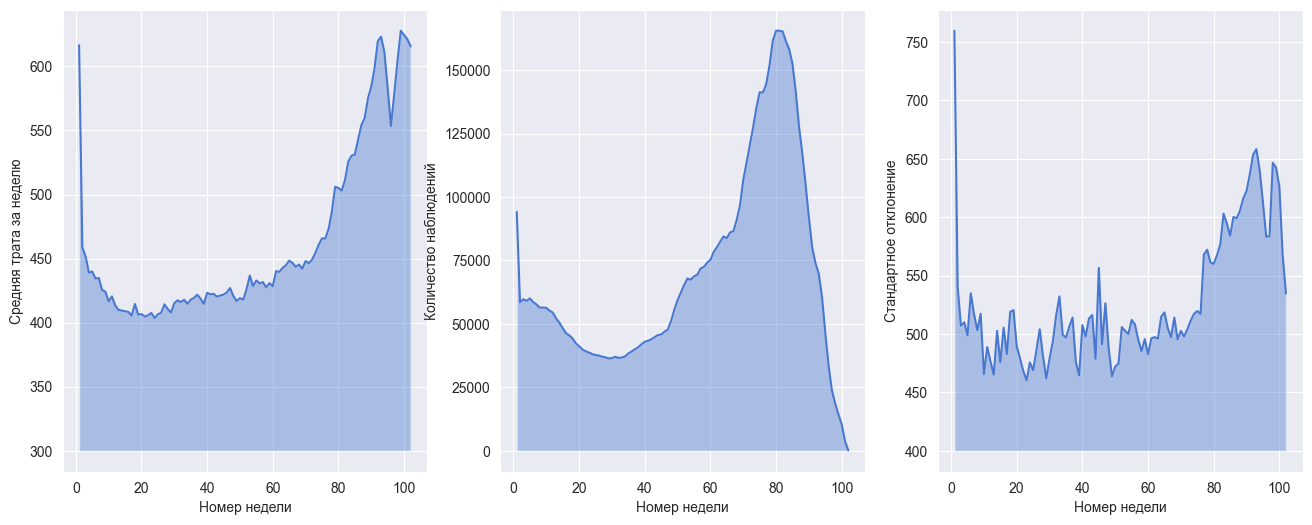

In [11]:
plt.figure(figsize=(16, 6))
sns.set_palette(palette='muted')
sns.set_style("darkgrid")
plt.subplot(131)
sns.lineplot(table, x='weeks', y='avg_purchase')
plt.fill_between(table.weeks, table.avg_purchase, 300, alpha=0.4)
plt.xlabel('Номер недели')
plt.ylabel('Средняя трата за неделю')
plt.subplot(132)
sns.lineplot(table, x='weeks', y='num_of_observation')
plt.fill_between(table.weeks, table.num_of_observation, alpha=0.4)
plt.xlabel('Номер недели')
plt.ylabel('Количество наблюдений')
plt.subplot(133)
sns.lineplot(table, x='weeks', y='std_purchase')
plt.fill_between(table.weeks, table.std_purchase, 400, alpha=0.4)
plt.xlabel('Номер недели')
plt.ylabel('Стандартное отклонение')
plt.show()

In [12]:
x1 = purchases[purchases.sum_purchase > 1000].groupby('weeks').agg({'sum_purchase': ['count']}).reset_index()
x1.columns = ['weeks', 'big_purch']
x2 = purchases.groupby('weeks').agg({'sum_purchase': ['count']}).reset_index()
x2.columns = ['weeks', 'all_purch']
x1 = pd.merge(x1, x2, on='weeks')
x1['big_purch_ratio'] = x1['big_purch'] / x1['all_purch']

In [47]:
purchases_a = purchases[['client_id', 'weeks']]
x_arr_count = []
counter_arr = []
for i in range(1, 91):
    t1 = purchases_a[(purchases_a.weeks == i)]
    t2 = purchases_a[(purchases_a.weeks == i+1)]
    x = pd.merge(t1, t2, on='client_id', how='left')
    counter_arr.append(x.iloc[:, 2].isna().sum() / x.shape[0])
    x_arr_count.append(i)

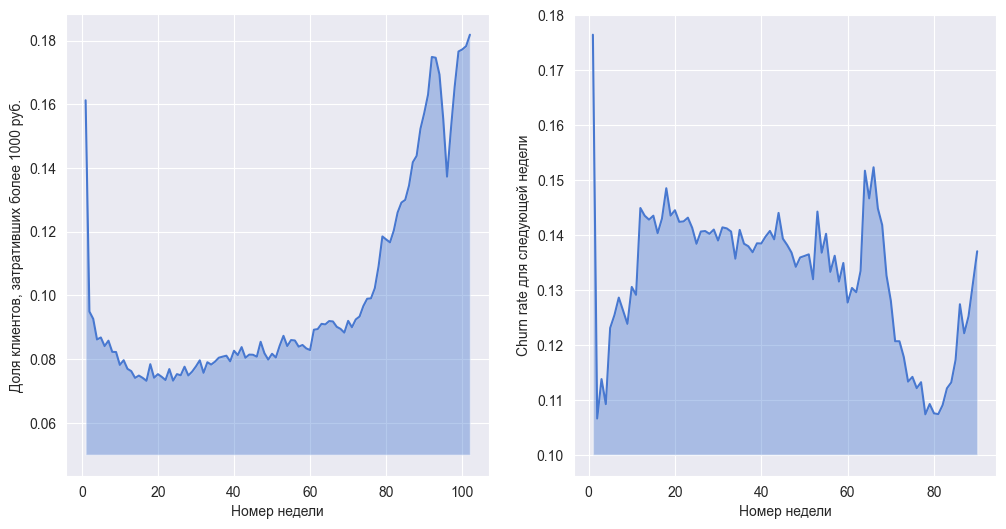

In [45]:
plt.figure(figsize=(12, 6))
sns.set_palette(palette='muted')
sns.set_style("darkgrid")
plt.subplot(121)
sns.lineplot(x1, x='weeks', y='big_purch_ratio')
plt.fill_between(x1.weeks, x1.big_purch_ratio, 0.05, alpha=0.4)
plt.xlabel('Номер недели')
plt.ylabel('Доля клиентов, затративших более 1000 руб.')
plt.subplot(122)
sns.lineplot(x=x_arr_count, y=counter_arr)
plt.fill_between(x_arr_count, counter_arr, 0.1, alpha=0.4)
plt.xlabel('Номер недели')
plt.ylabel('Churn rate для следующей недели')
plt.show()

In [61]:
purchases_a = purchases[['client_id', 'weeks']]
x_arr_count_m = []
counter_arr_m = []
for i in range(1, 91):
    t1 = set(purchases_a[(purchases_a.weeks == i)].client_id.tolist())
    t2 = set(purchases_a[(purchases_a.weeks >= i+1) & (purchases_a.weeks <= i+4)].client_id.tolist())
    counter_arr_m.append(len(t1.intersection(t2)) / len(t1))
    x_arr_count_m.append(i)

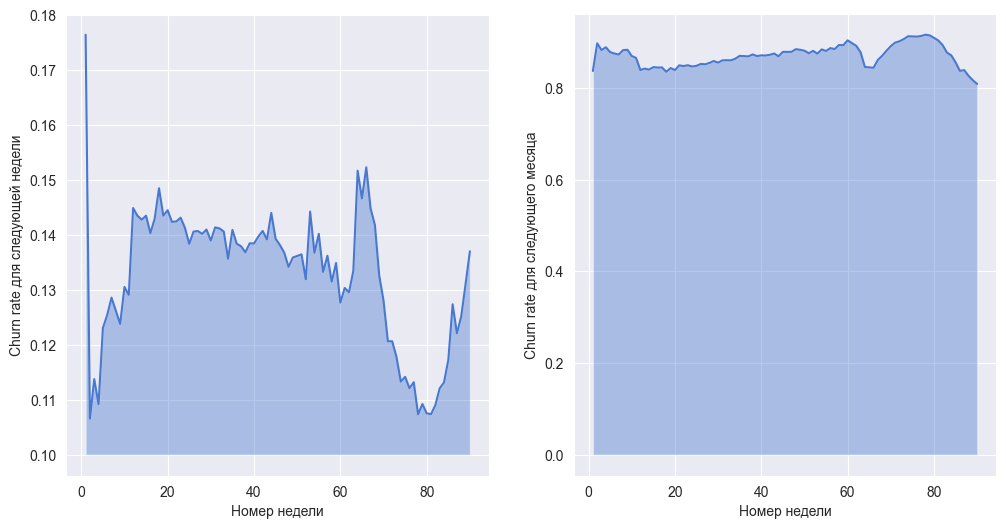

In [65]:
plt.figure(figsize=(12, 6))
sns.set_palette(palette='muted')
sns.set_style("darkgrid")

plt.subplot(121)
sns.lineplot(x=x_arr_count, y=counter_arr)
plt.fill_between(x_arr_count, counter_arr, 0.1, alpha=0.4)
plt.xlabel('Номер недели')
plt.ylabel('Churn rate для следующей недели')

plt.subplot(122)
sns.lineplot(x=x_arr_count_m, y=counter_arr_m)
plt.fill_between(x_arr_count_m, counter_arr_m, 0, alpha=0.4)
plt.xlabel('Номер недели')
plt.ylabel('Churn rate для следующего месяца')

plt.show()

In [66]:
purchases_a = purchases[['client_id', 'weeks']]
x_arr_count_m = []
counter_arr_m = []
for i in range(1, 91):
    t1 = set(purchases_a[(purchases_a.weeks == i)].client_id.tolist())
    t1_ = t1.copy()
    for j in range(1, 5):
        t2 = set(purchases_a[purchases_a.weeks >= i+j].client_id.tolist())
        t1 = t1.intersection(t2)
    counter_arr_m.append(len(t1) / len(t1_))
    x_arr_count_m.append(i)

In [76]:
purchases_a = purchases[['client_id', 'weeks']]
x_jjj = []
counter_jjj = []
for i in range(1, 91):
    t1 = set(purchases_a[(purchases_a.weeks == i)].client_id.tolist())
    t2 = set(purchases_a[(purchases_a.weeks >= i+1)].client_id.tolist())
    t3 = set(purchases_a[(purchases_a.weeks >= i+1) & (purchases_a.weeks <= i+4)].client_id.tolist())
    T1 = t1 - t1.intersection(t2)
    T2 = t1 - t1.intersection(t3)
    counter_jjj.append(len(T1) / len(T2))
    x_jjj.append(i)

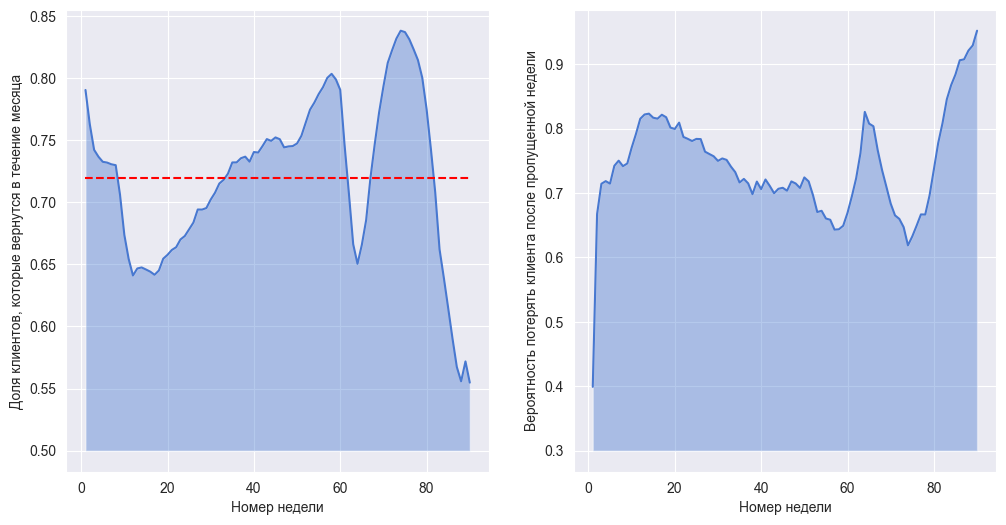

In [79]:
plt.figure(figsize=(12, 6))
sns.set_palette(palette='muted')
sns.set_style("darkgrid")

plt.subplot(121)

sns.lineplot(x=x_arr_count_m, y=counter_arr_m)
plt.fill_between(x_arr_count_m, counter_arr_m, 0.5, alpha=0.4)
plt.hlines(np.array(counter_arr_m).mean(), xmin=1, xmax=90, color='r', linestyle='--')
plt.xlabel('Номер недели')
plt.ylabel('Доля клиентов, которые вернутся в течение месяца')

plt.subplot(122)

sns.lineplot(x=x_jjj, y=counter_jjj)
plt.fill_between(x_jjj, counter_jjj, 0.3, alpha=0.4)
plt.xlabel('Номер недели')
plt.ylabel('Вероятность потерять клиента после пропущенной недели')

plt.show()

Как мы видим, самые преданные клиенты тратят больше. Также много тратят самые новые клиенты. Клиенты, оформившие карту больше 70 недель назад, в среднем тратят намного больше, тем более видим резкий рост. Выдвинем гипотезу: клиенты после 70 недели увеличивают средние траты, при этом клиенты, тратившие ниже среднего в предыдущие недели, перестают пользоваться услугами.

In [33]:
part_of_weeks = purchases.groupby('weeks').sum_purchase.sum().reset_index()
part_of_weeks.columns = ['weeks', 'sum_purchase']

In [99]:
bins = [0, 4, 10, 30, 50, 70, 90, np.inf]
labels = ['1-4', '5-10', '11-30', '31-50', '51-70', '71-90', '91+']
part_of_weeks['categories'] = pd.cut(part_of_weeks['weeks'], bins=bins, labels=labels, right=True)
groups_impact = part_of_weeks.groupby('categories', observed=True).sum_purchase.sum().reset_index()
groups_impact['ratio'] = groups_impact.sum_purchase / groups_impact.sum_purchase.sum() *100

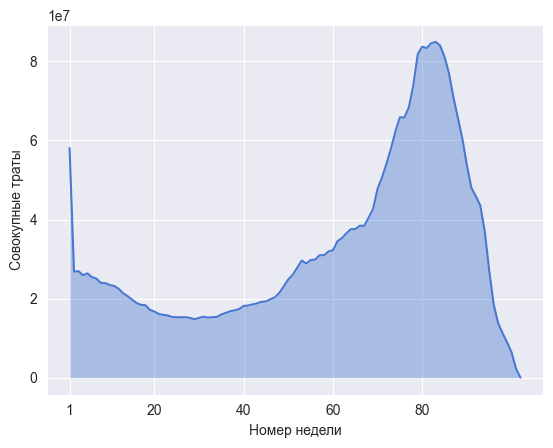

In [100]:
sns.lineplot(part_of_weeks, x='weeks', y='sum_purchase')
plt.xlabel('Номер недели')
plt.ylabel('Совокупные траты')
plt.fill_between(part_of_weeks.weeks, part_of_weeks.sum_purchase, alpha=0.4)
plt.xticks([1, 20, 40, 60, 80])
plt.show()

Можем видеть, что клиенты, использующие карту от 70 до 90 недели вносят наибольший вклад в выручку компании.

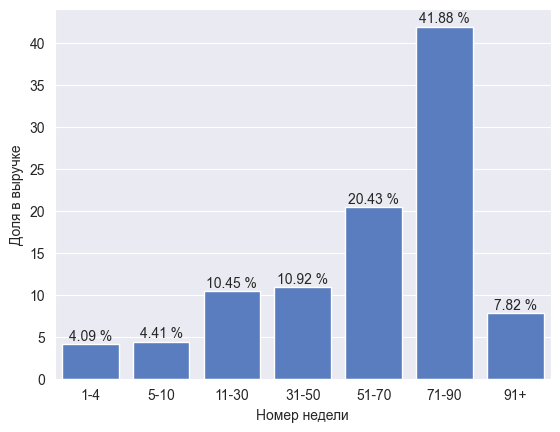

In [101]:
ax = sns.barplot(groups_impact, x='categories', y='ratio')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.5, f'{p.get_height():.2f} %',ha='center')
plt.xlabel('Номер недели')
plt.ylabel('Доля в выручке')
plt.show()

In [107]:
clients_by_weeks = purchases.groupby('weeks').client_id.nunique().reset_index()
labels = ['1-4', '5-10', '11-30', '31-50', '51-70', '71-90', '91+']
clients_by_weeks['categories'] = pd.cut(clients_by_weeks['weeks'], bins=bins, labels=labels, right=True)
cls_groups_impact = clients_by_weeks.groupby('categories', observed=True).client_id.sum().reset_index()
cls_groups_impact['ratio'] = cls_groups_impact.client_id / cls_groups_impact.client_id.sum() * 100

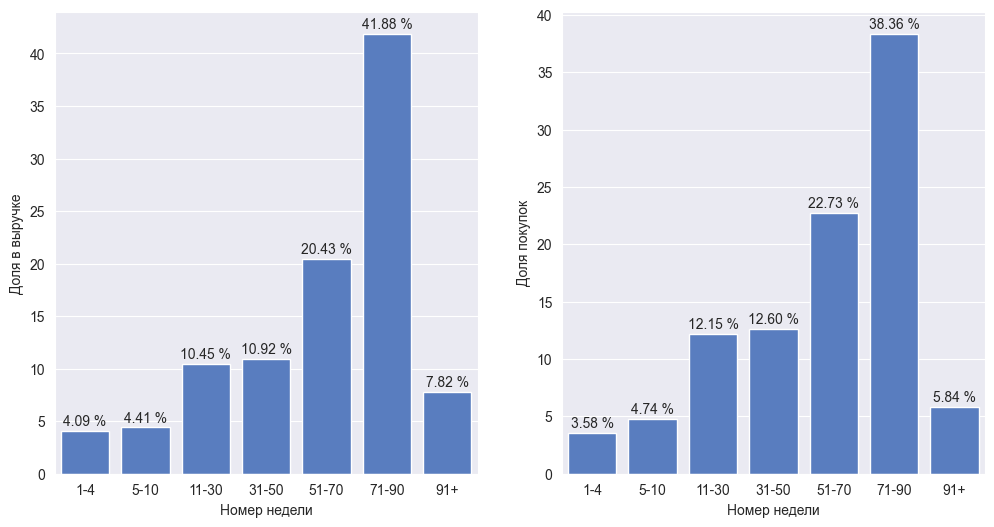

In [108]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
ax = sns.barplot(groups_impact, x='categories', y='ratio')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.5, f'{p.get_height():.2f} %',ha='center')
plt.xlabel('Номер недели')
plt.ylabel('Доля в выручке')
plt.subplot(122)
ax = sns.barplot(cls_groups_impact, x='categories', y='ratio')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.5, f'{p.get_height():.2f} %',ha='center')
plt.xlabel('Номер недели')
plt.ylabel('Доля покупок')
plt.show()

На иллюстрации мы еще раз можем видеть, что группа от 71 до 90 недели вносит вклад не только числом покупателей, но и их "весом". 

In [109]:
purch = purchases.copy()

In [110]:
clients_70 = purchases[purchases.weeks == 70].client_id.unique()
purch['weeks_to_end'] = ((purch.transaction_datetime.max() - purch.transaction_datetime) / datetime.timedelta(days=1)).astype(int) + 1
purch70 = purch[(purch.weeks > 70) & (purch.weeks <= 80) & (purch.client_id.isin(clients_70) & (purch.weeks_to_end >= 10))]
churn = purch70.groupby('weeks').client_id.count()

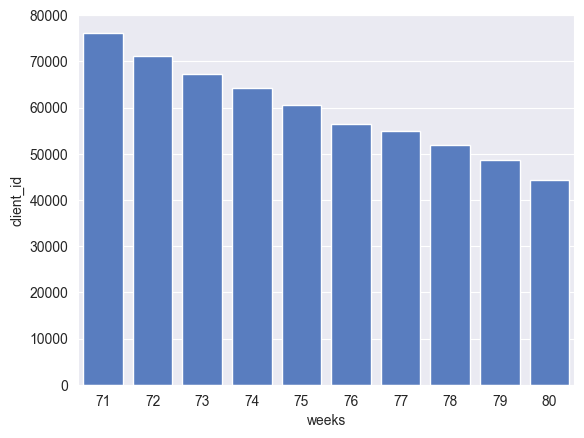

In [111]:
sns.barplot(churn)
plt.show()

In [112]:
begin = 20
size = 10

clients_ind = purchases[purchases.weeks == begin].client_id.unique()
purch['weeks_to_end'] = ((purch.transaction_datetime.max() - purch.transaction_datetime) / datetime.timedelta(days=1)).astype(int) + 1
purch_ind = purch[(purch.weeks > begin) & (purch.weeks <= begin + size) & (purch.client_id.isin(clients_ind) & (purch.weeks_to_end >= size))]
churn = purch_ind.groupby('weeks').client_id.count()

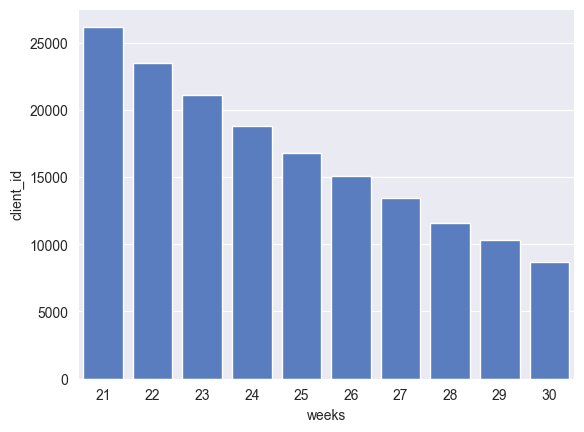

In [113]:
sns.barplot(churn)
plt.show()

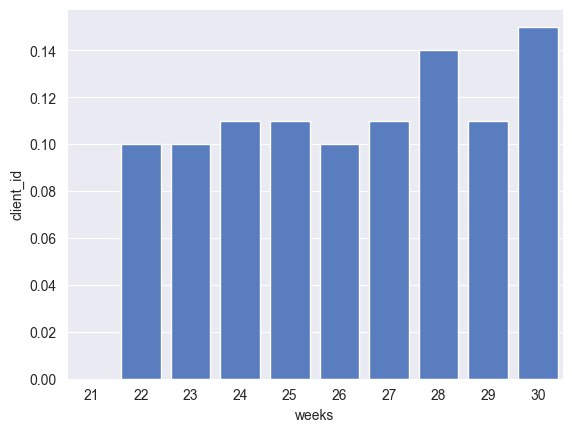

In [114]:
sns.barplot(np.round(1 - churn / churn.shift(1), 2))
plt.show()

In [115]:
begin = 70
size = 10

clients_ind = purchases[purchases.weeks == begin].client_id.unique()
purch['weeks_to_end'] = ((purch.transaction_datetime.max() - purch.transaction_datetime) / datetime.timedelta(days=1)).astype(int) + 1
purch_ind = purch[(purch.weeks > begin) & (purch.weeks <= begin + size) & (purch.client_id.isin(clients_ind) & (purch.weeks_to_end >= size))]
churn = purch_ind.groupby('weeks').client_id.count()

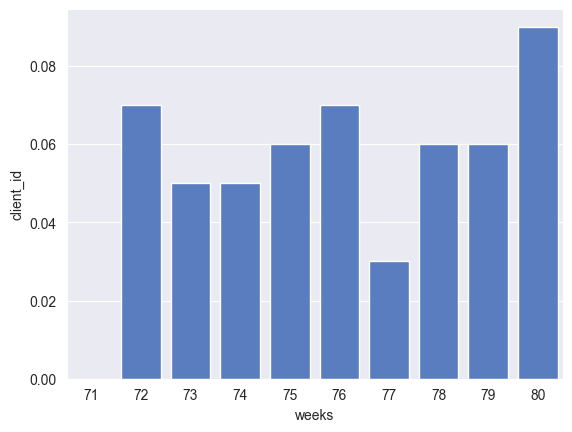

In [116]:
sns.barplot(np.round(1 - churn / churn.shift(1), 2))
plt.show()

In [117]:
merged = pd.merge(clients[['client_id']], 
                  purchases[['client_id', 'weeks', 'sum_purchase']], 
                  on='client_id', how='left')

In [118]:
merged.head()

,client_id,weeks,sum_purchase
0,000012768d,70,1007
1,000012768d,72,575
2,000012768d,83,804
3,000012768d,84,419
4,000036f903,86,241


Всего в наших наблюдениях покупок более 16 недель. Значит, для каждого клиента, который совершал покупки на 70-ую неделю, мы можем проследить дальнейшую историю: он мог прекратить покупки совсем, не покупать в некоторые из недель или, наоборот, увеличить недельные траты.

In [119]:
(purchases.transaction_datetime.max() - purchases.transaction_datetime.min()).days / 7

16.714285714285715

Границы наблюдаемого периода выглядят так.

In [120]:
purchases.transaction_datetime.min(), purchases.transaction_datetime.max()

(datetime.date(2018, 11, 21), datetime.date(2019, 3, 18))

Отсортируем только тех клиентов, для которых с 70 по 79 неделю целиком попали на выбранный промежуток.

In [121]:
clnts = clients[(clients.first_issue_date >= purchases.transaction_datetime.min() - pd.Timedelta(days=69*7)) &
                (clients.first_issue_date <= purchases.transaction_datetime.max() - pd.Timedelta(days=10*7))].client_id.tolist()

# Посчитаем количество клиентов
print(len(clnts))

270191


Выборка остается внушительной. Посмотрим, сколько из них не совершили ни одной покупки на данном временном интервале.

In [122]:
purchases.client_id[purchases.client_id.isin(clnts)].nunique()

270191

Таких не оказалось. Будем честны, но в реальности, на более полных данных мы бы обнаружили много таких клиентов. Будем держать в голове мысль о смещенности выборки, однако большое количество наблюдений может помочь асимптотически прийти к правильным выводам.

In [123]:
clnts_df = clients[['client_id', 'first_issue_date']][clients.client_id.isin(clnts)]

In [124]:
olds = pd.merge(clnts_df, purchases[['client_id', 'transaction_datetime', 'sum_purchase']], on='client_id', how='left')
olds['weeks'] = ((pd.to_datetime(olds.transaction_datetime) - pd.to_datetime(olds.first_issue_date)).dt.days / 7).astype(int) + 1
olds = olds[['client_id', 'weeks', 'sum_purchase']]
olds = olds[(olds.weeks >= 70) & (olds.weeks <= 79)]

In [125]:
olds.head()

,client_id,weeks,sum_purchase
0,000012768d,70,1007
1,000012768d,72,575
20,00007f9014,70,376
21,00007f9014,71,282
22,00007f9014,71,227


In [126]:
olds = olds.groupby(['client_id', 'weeks']).sum_purchase.sum().reset_index()

In [127]:
olds = pd.pivot(olds, index='client_id', columns='weeks', values='sum_purchase').fillna(0).astype(int).reset_index()

Видим, что нулей достаточно много.

In [128]:
olds.head()

weeks,client_id,70,71,72,73,74,75,76,77,78,79
0,000012768d,1007,0,575,0,0,0,0,0,0,0
1,00007f9014,376,509,1033,0,0,200,0,110,1054,758
2,0002ce2217,0,0,129,0,223,0,0,0,562,131
3,00042a927a,0,0,307,766,1314,0,0,0,0,0
4,0005ce475d,538,1825,3530,470,1000,1759,0,389,341,1296


In [129]:
weeks_ = olds.columns.tolist()[1:]
olds = pd.melt(olds, id_vars=['client_id'], value_vars=weeks_, value_name='purchase_sum')

In [130]:
weeks_nums = pd.merge(olds[olds.purchase_sum > 0].groupby('weeks').purchase_sum.count().reset_index(), 
    olds.groupby('weeks').purchase_sum.count().reset_index(), on='weeks')
weeks_nums.columns = ['weeks', 'notnull', 'total']
weeks_nums['normal_clients'] = weeks_nums['notnull'] / weeks_nums['total']

Доля клиентов, потративших более 0 рублей, уменьшается на 2 процента с каждой неделей.

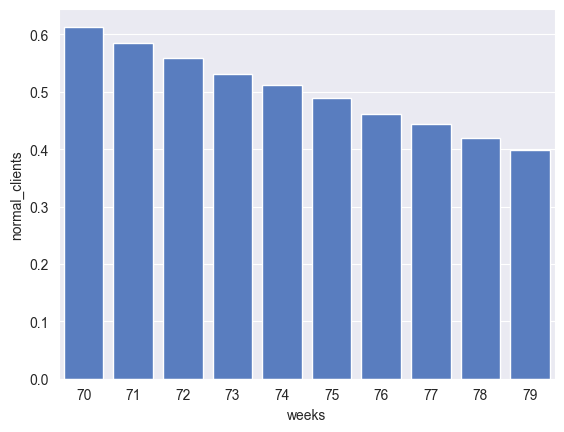

In [131]:
sns.barplot(weeks_nums[['weeks', 'normal_clients']], x='weeks', y='normal_clients')
plt.show()

Возьмем за базовую неделю 70-ую. Рассмотрим только тех клиентов, которые потратили на 70-й неделе некоторую сумму.

In [132]:
lst_of_cls = olds[(olds.purchase_sum > 0) & (olds.weeks == 70)].client_id.tolist()
cls70 = olds[olds.client_id.isin(lst_of_cls)]

In [133]:
weeks_nums = pd.merge(cls70[cls70.purchase_sum > 0].groupby('weeks').purchase_sum.count().reset_index(), 
    cls70.groupby('weeks').purchase_sum.count().reset_index(), on='weeks')
weeks_nums.columns = ['weeks', 'notnull', 'total']
weeks_nums['normal_clients'] = weeks_nums['notnull'] / weeks_nums['total']

Видим резкое падение после 70-й недели. Это означает, что retention rate для данной группы чуть более 0.6, для большего временного окна снижается на те же 2 процента в неделю.

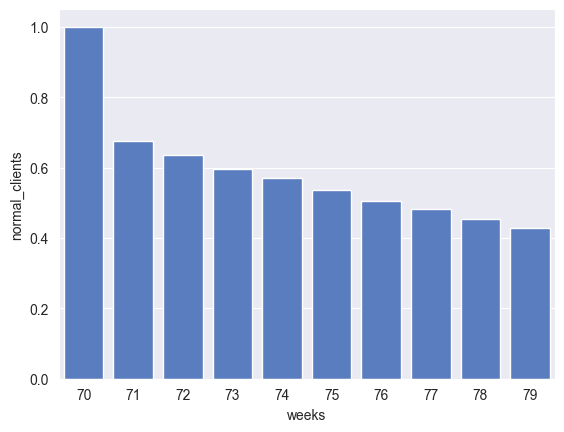

In [134]:
sns.barplot(weeks_nums[['weeks', 'normal_clients']], x='weeks', y='normal_clients')
plt.show()

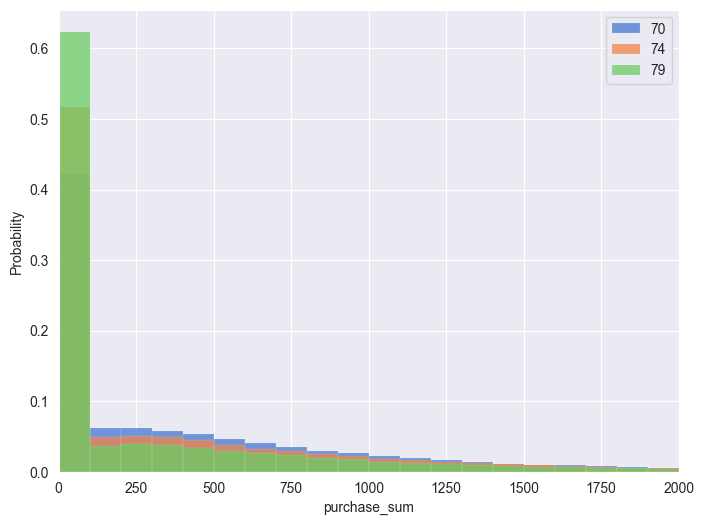

In [135]:
plt.figure(figsize=(8, 6))
sns.histplot(olds[olds.weeks == 70].purchase_sum, binwidth=100, stat='probability', label='70')
sns.histplot(olds[olds.weeks == 74].purchase_sum, binwidth=100, stat='probability', label='74')
sns.histplot(olds[olds.weeks == 79].purchase_sum, binwidth=100, stat='probability', label='79')
plt.xlim(0, 2000)
plt.legend()
plt.show()

In [136]:
lst = olds[(olds.weeks == 70) & (olds.purchase_sum > 0)].client_id.tolist()
mean_by_weeks_nozero = olds[olds.client_id.isin(lst) & (olds.purchase_sum > 0)].groupby('weeks').purchase_sum.mean().reset_index()
mean_by_weeks = olds.groupby('weeks').purchase_sum.mean().reset_index()

Чисто визуально мы видим тренд: среднее значение трат покупателя снижается, но основано это на том, что некоторые клиенты просто перестают пользоваться услугами магазина. Другой тренд состоит в том, что верные компании клиенты тратят в среднем тратят больше, чем прежде, или, по крайней мере не меньше. Мы можем проверить эти изменения t-тестом.

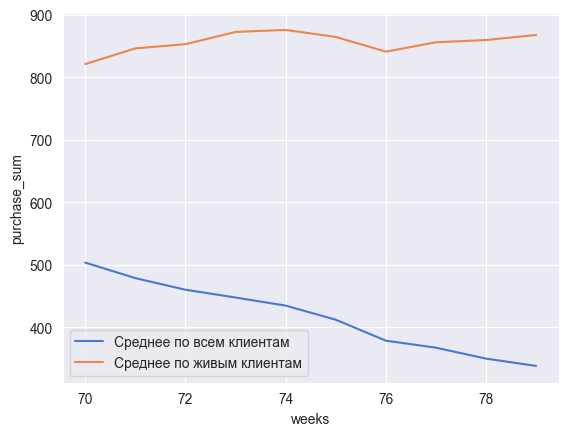

In [137]:
sns.lineplot(mean_by_weeks, x='weeks', y='purchase_sum', label='Среднее по всем клиентам')
sns.lineplot(mean_by_weeks_nozero, x='weeks', y='purchase_sum', label='Среднее по живым клиентам')
plt.show()

In [138]:
active_clients = olds[olds.client_id.isin(lst) & (olds.purchase_sum > 0)]

In [139]:
for i in range(10):
    if ttest_ind(active_clients[active_clients.weeks == 70+i].purchase_sum, 
              active_clients[active_clients.weeks == 71+i].purchase_sum, alternative='less').pvalue < 0.05:
        print(f'Наблюдается рост средней суммы между {70+i} и {71+i} неделями')
    else:
        print(f'Не наблюдается рост средней суммы между {70+i} и {71+i} неделями')

Наблюдается рост средней суммы между 70 и 71 неделями
Не наблюдается рост средней суммы между 71 и 72 неделями
Наблюдается рост средней суммы между 72 и 73 неделями
Не наблюдается рост средней суммы между 73 и 74 неделями
Не наблюдается рост средней суммы между 74 и 75 неделями
Не наблюдается рост средней суммы между 75 и 76 неделями
Наблюдается рост средней суммы между 76 и 77 неделями
Не наблюдается рост средней суммы между 77 и 78 неделями
Не наблюдается рост средней суммы между 78 и 79 неделями
Не наблюдается рост средней суммы между 79 и 80 неделями


Статистически значимо мы можем сказать, что лишь в некоторые недели происходит рост средней суммы трат.

Если задать вопрос о том, изменилась ли за 10 недель средняя потраченная сумма, то ответ будет положительным.

In [140]:
if ttest_ind(active_clients[active_clients.weeks == 70].purchase_sum, 
              active_clients[active_clients.weeks == 79].purchase_sum, alternative='less').pvalue < 0.05:
        print(f'Наблюдается рост средней суммы между 70 и 79 неделями')
else:
        print(f'Не наблюдается рост средней суммы между 70 и 79 неделями')

Наблюдается рост средней суммы между 70 и 79 неделями


Поэтому мы можем сказать, что выдвинутая прежде гипотеза подтвердилась: действительно, рост средней потраченной суммы происходит, в основном, за счет того, что старые клиенты тратят больше, чем прежде. Рост незначительный, на некоторых промежутках не распознается как статистически значимый. Стоит отметить, что наблюдаемый эффект может быть вызван общим ростом уровня цен, инфляцией.

Рассмотрим клиентов, которые тратили на 70-й неделе, а затем стали "мертвыми". Как это связано с потраченной суммой и их половозрастными характеристиками.

In [150]:
purch.head()

,client_id,transaction_datetime,weeks,sum_purchase,weeks_to_end
0,000012768d,2018-12-01,70,1007,108
1,000012768d,2018-12-16,72,575,93
2,000012768d,2019-03-08,83,804,11
3,000012768d,2019-03-14,84,419,5
4,000036f903,2018-11-28,86,241,111


In [157]:
research_group = set(purch[(purch.sum_purchase > 0) & (purch.weeks == 70)].client_id) - set(purch[(purch.sum_purchase > 0) & (purch.weeks > 70)].client_id)

In [251]:
research_df = clients[clients.client_id.isin(research_group)][['client_id', 'age', 'gender']]
research_df2 = purch[(purch.client_id.isin(research_group)) & (purch.weeks == 70)][['client_id', 'sum_purchase']]
research_df = pd.merge(research_df, research_df2, on='client_id', how='outer')
research_df = research_df[(research_df.age > 0) & (research_df.age < 100)]

In [197]:
research_df.head()

,client_id,age,gender,sum_purchase
0,0036546652,43,U,1100
1,0041cc521b,47,U,99
2,0047ad7b53,43,U,451
3,004a0adcfb,71,U,910
4,004f98c1b4,36,F,703


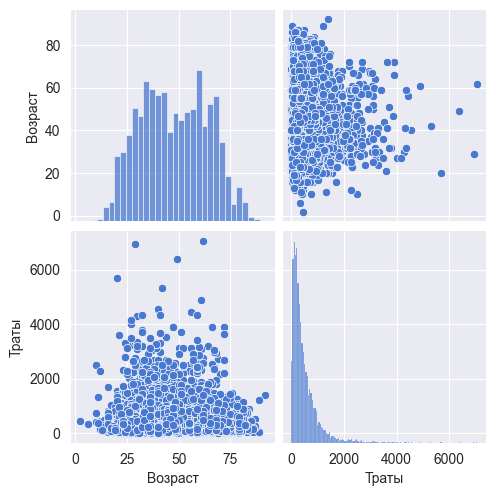

In [259]:
sns.pairplot(research_df[['age', 'sum_purchase']].rename({'age': 'Возраст', 'sum_purchase': "Траты"}, axis=1))
plt.show()

In [235]:
control_df = clients[~clients.client_id.isin(research_group)][['client_id', 'age', 'gender']]
control_df2 = purch[(~purch.client_id.isin(research_group)) & (purch.weeks == 70)][['client_id', 'sum_purchase']]
control_df = pd.merge(control_df, control_df2, on='client_id', how='right')
control_df = control_df[(control_df.age > 0) & (control_df.age < 100)]

research_df = research_df.iloc[:, 1:]
research_df = pd.get_dummies(research_df, columns=['gender'], drop_first=True, dtype=int)
research_df = sm.add_constant(research_df)

control_df = control_df.iloc[:, 1:]
control_df = pd.get_dummies(control_df, columns=['gender'], drop_first=True, dtype=int)
control_df = sm.add_constant(control_df)

control_df['target'] = 0
research_df['target'] = 1

In [236]:
X = pd.concat((control_df, research_df), axis=0)
y = X.target
X.drop(['target'], axis=1, inplace=True)

In [242]:
model = sm.Logit(y, X).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.229007
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               106421
Model:                          Logit   Df Residuals:                   106416
Method:                           MLE   Df Model:                            4
Date:                Mon, 23 Sep 2024   Pseudo R-squ.:                0.001533
Time:                        18:07:14   Log-Likelihood:                -24371.
converged:                       True   LL-Null:                       -24409.
Covariance Type:            nonrobust   LLR p-value:                 2.153e-15
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.8503      0.047    -60.222      0.000      -2.943      -2.758
age             -0.0007

In [238]:
X_tranformed = X.copy()
X_tranformed['age**2'] = X_tranformed.age ** 2
X_tranformed['sum_purchase**2'] = X_tranformed.sum_purchase ** 2

In [241]:
model = sm.Logit(y, X_tranformed).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.228689
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               106421
Model:                          Logit   Df Residuals:                   106414
Method:                           MLE   Df Model:                            6
Date:                Mon, 23 Sep 2024   Pseudo R-squ.:                0.002920
Time:                        18:07:10   Log-Likelihood:                -24337.
converged:                       True   LL-Null:                       -24409.
Covariance Type:            nonrobust   LLR p-value:                 2.877e-28
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.2158      0.107    -20.773      0.000      -2.425      -2.007
age           

Мы видим, что мужчины более склонны прекращать покупки, даже будучи постоянными клиентами, то же наблюдается и у людей с не указанным гендером. В силу неполноты знаний, мы не можем сказать точно, по каким причинам это происходит. Если выдвинуть и подтвердить гипотезу о том, что клиенты-мужчины чаще забывают использовать карту лояльности, то наблюдаемый эффект будет объяснен. И тогда мы не сможем сказать, что клиенты-мужчины более склонны отказываться от услуг даже после длительного сотрудничества.

Если вычислять производную по sum_purchase, то максимизирующая отток сумма затрат -- 300 р. Те, кто тратит меньше или больше реже подвержены оттоку. Это можно было бы объяснить тем, что клиенты, которые тратят меньше, продолжают формат мелких покупок и не становятся "мертвыми" клиентами, а клиенты, в среднем затрачивающие более попадают в ту самую группу постоянных клиентов, средние затраты которых в районе 800 р. и только нарастают с неделями.

Давайте рассмотрим еще один вопрос о той же категории покупателей: почему дисперсия в группе 70-90 недель выше, чем в группах с меньшим количеством недель пользования картой. Возможно, это свойство датасета, возможно, закономерность. Ранее мы изображали на графиках:

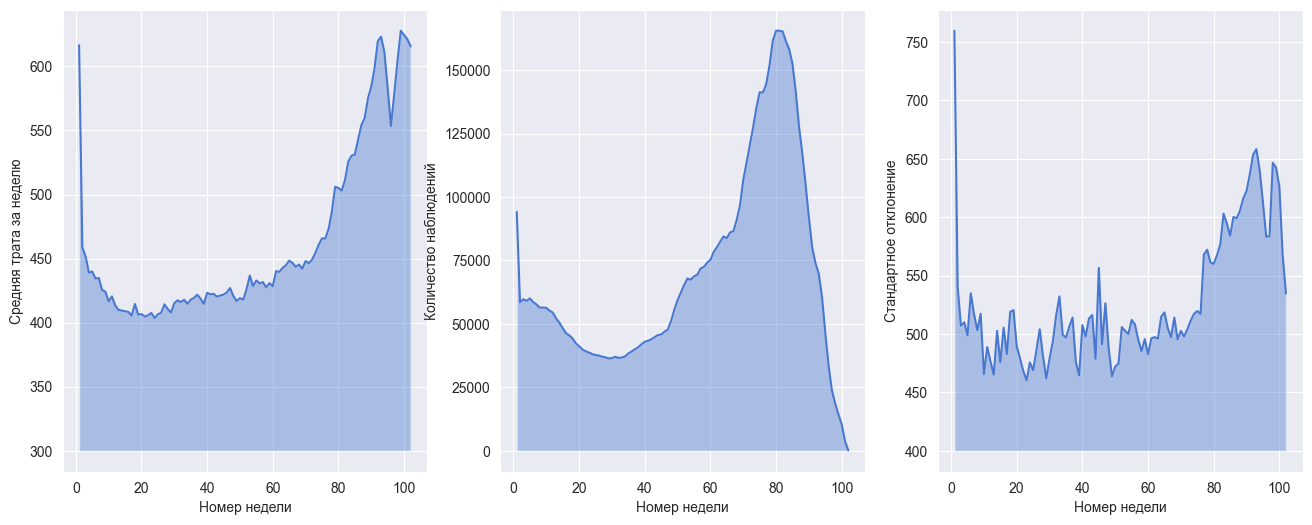

In [243]:
plt.figure(figsize=(16, 6))
sns.set_palette(palette='muted')
sns.set_style("darkgrid")
plt.subplot(131)
sns.lineplot(table, x='weeks', y='avg_purchase')
plt.fill_between(table.weeks, table.avg_purchase, 300, alpha=0.4)
plt.xlabel('Номер недели')
plt.ylabel('Средняя трата за неделю')
plt.subplot(132)
sns.lineplot(table, x='weeks', y='num_of_observation')
plt.fill_between(table.weeks, table.num_of_observation, alpha=0.4)
plt.xlabel('Номер недели')
plt.ylabel('Количество наблюдений')
plt.subplot(133)
sns.lineplot(table, x='weeks', y='std_purchase')
plt.fill_between(table.weeks, table.std_purchase, 400, alpha=0.4)
plt.xlabel('Номер недели')
plt.ylabel('Стандартное отклонение')
plt.show()

In [263]:
purch_group = purch[['weeks', 'sum_purchase']]
bins = [0, 4, 10, 30, 50, 70, 90, np.inf]
labels = ['1-4', '5-10', '11-30', '31-50', '51-70', '71-90', '91+']
purch_group['categories'] = pd.cut(purch_group['weeks'], bins=bins, labels=labels, right=True)

In [264]:
purch_group.head()

,weeks,sum_purchase,categories
0,70,1007,51-70
1,72,575,71-90
2,83,804,71-90
3,84,419,71-90
4,86,241,71-90


In [267]:
purch_group_std = purch_group.groupby('categories').sum_purchase.std().reset_index()

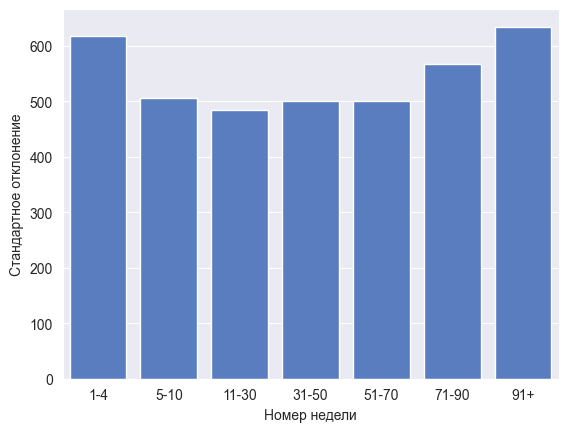

In [268]:
sns.barplot(purch_group_std, x='categories', y='sum_purchase')
plt.xlabel('Номер недели')
plt.ylabel('Стандартное отклонение')
plt.show()

Высокие значения стандартного отклонения в группе 1-4 объяснить достаточно просто: новый клиент еще не выбрал стратегию взаимодействия с магазином, дополнительный фактор в виде бонусов и скидок позволяет тратить суммы, значительно больше обычного. Но вопрос: почему рост стандартного отклонения мы наблюдаем для постоянных клиентов после 70-й недели?

Сначала проверим, за счет чего происходит это изменение: за счет увеличения количества нулевых трат или большего веса хвоста распределения.

In [ ]:
[(purch_group.categories == '51-70') | (purch_group.categories == '31-50')]

In [292]:
purch_group[(purch_group.categories == '51-70') | (purch_group.categories == '31-50')].categories

0          51-70
71         51-70
72         51-70
73         51-70
74         51-70
           ...  
7145595    51-70
7145596    51-70
7145597    51-70
7145598    51-70
7145599    51-70
Name: categories, Length: 2445741, dtype: category
Categories (7, object): ['1-4' < '5-10' < '11-30' < '31-50' < '51-70' < '71-90' < '91+']

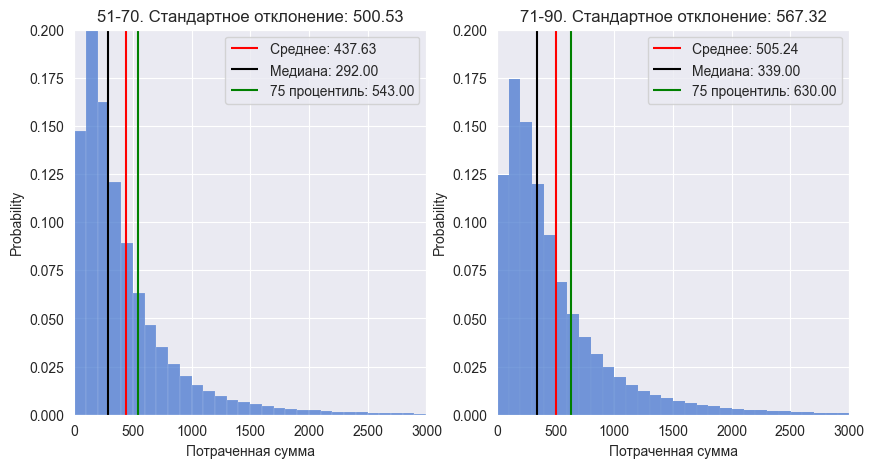

In [322]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
std_1 = purch_group[purch_group.categories == '51-70'].sum_purchase.std()
plt.title(f'51-70. Стандартное отклонение: {std_1:.2f}')
sns.histplot(purch_group[purch_group.categories == '51-70'], x='sum_purchase', stat='probability', binwidth=100)
m1 = purch_group[purch_group.categories == '51-70'].sum_purchase.mean()
med1 = purch_group[purch_group.categories == '51-70'].sum_purchase.median()
q1 = purch_group[purch_group.categories == '51-70'].sum_purchase.quantile(0.75)
plt.vlines(x=m1, ymin=0, ymax=0.2, color='red', label=f'Среднее: {m1:.2f}')
plt.vlines(x=med1, ymin=0, ymax=0.2, color='black', label=f'Медиана: {med1:.2f}')
plt.vlines(x=q1, ymin=0, ymax=0.2, color='green', label=f'75 процентиль: {q1:.2f}')
plt.xlabel('Потраченная сумма')
plt.legend()
plt.xlim(0, 3000)
plt.ylim(0, 0.2)
plt.subplot(122)
std_2 = purch_group[purch_group.categories == '71-90'].sum_purchase.std()
plt.title(f'71-90. Стандартное отклонение: {std_2:.2f}')
sns.histplot(purch_group[purch_group.categories == '71-90'], x='sum_purchase', stat='probability', binwidth=100)
m2 = purch_group[purch_group.categories == '71-90'].sum_purchase.mean()
med2 = purch_group[purch_group.categories == '71-90'].sum_purchase.median()
q2 = purch_group[purch_group.categories == '71-90'].sum_purchase.quantile(0.75)
plt.vlines(x=m2, ymin=0, ymax=0.2, color='red',  label=f'Среднее: {m2:.2f}')
plt.vlines(x=med2, ymin=0, ymax=0.2, color='black', label=f'Медиана: {med2:.2f}')
plt.vlines(x=q2, ymin=0, ymax=0.2, color='green', label=f'75 процентиль: {q2:.2f}')
plt.xlabel('Потраченная сумма')
plt.legend()
plt.xlim(0, 3000)
plt.ylim(0, 0.2)
plt.show()

Как можем судить по гистограммному изображению плотности распределения, правый хвост у второго распределения имеет больший вес, перемещение медианы относительно среднего менее значимо.

In [11]:
purchases.head()

,client_id,transaction_datetime,weeks,sum_purchase
0,000012768d,2018-12-01,70,1007
1,000012768d,2018-12-16,72,575
2,000012768d,2019-03-08,83,804
3,000012768d,2019-03-14,84,419
4,000036f903,2018-11-28,86,241


In [12]:
clients

,client_id,first_issue_date,age,gender
0,000012768d,2017-08-05,45,U
1,000036f903,2017-04-10,72,F
2,000048b7a6,2018-12-15,68,F
3,000073194a,2017-05-23,60,F
4,00007c7133,2017-05-22,67,U
...,...,...,...,...
400157,fffece623e,2018-05-13,67,U
400158,ffff3dfff8,2018-11-01,56,F
400159,ffffaab9da,2017-08-25,23,F
400160,ffffeb5619,2017-12-05,62,U


In [31]:
cls_start = purchases[purchases.client_id.isin(clients[clients.first_issue_date >= purchases.transaction_datetime.min()].client_id)].groupby('client_id').weeks.min().reset_index()
cls_start = pd.merge(cls_start, purchases, on=['client_id', 'weeks'], how='left').groupby(['client_id', 'weeks']).sum_purchase.sum().reset_index()

In [32]:
cls_start.head()

,client_id,weeks,sum_purchase
0,000048b7a6,1,445
1,0000eecb82,1,122
2,00035a21d9,1,1007
3,00038f9200,1,311
4,0004315e57,1,531


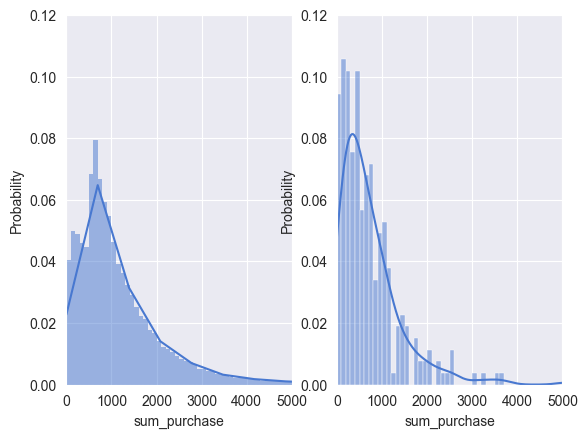

In [49]:
plt.subplot(121)
sns.histplot(cls_start[cls_start.weeks == 1].sum_purchase, binwidth=100, stat='probability', kde=True)
plt.xlim(0, 5000)
plt.ylim(0, 0.12)
plt.subplot(122)
sns.histplot(cls_start[cls_start.weeks > 1].sum_purchase, binwidth=100, stat='probability', kde=True)
plt.xlim(0, 5000)
plt.ylim(0, 0.12)
plt.show()

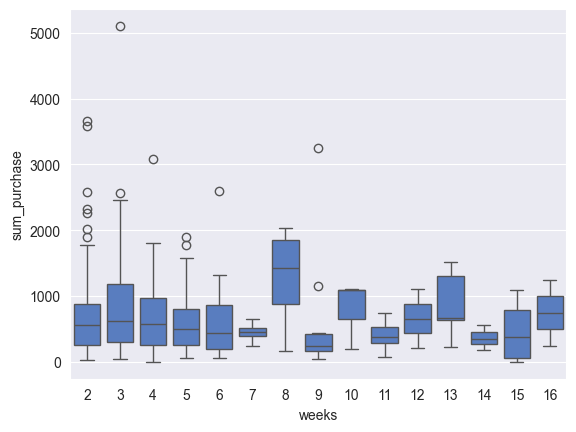

In [37]:
sns.boxplot(cls_start[cls_start.weeks > 1], x='weeks', y='sum_purchase')
plt.show()

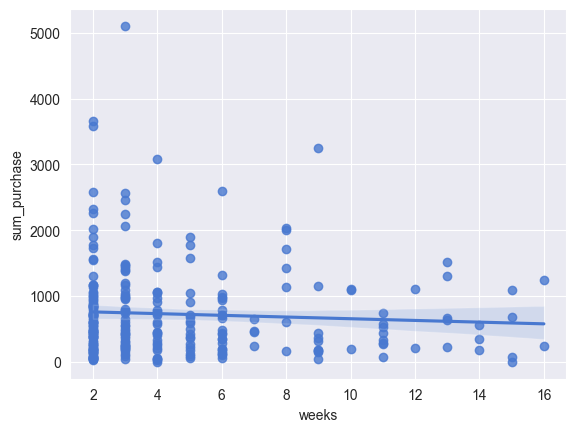

In [40]:
sns.regplot(cls_start[cls_start.weeks > 1], x='weeks', y='sum_purchase')
plt.show()

In [85]:
def estimate_sample_size(effect, std, alpha, beta):
    """Оценка необходимого размер групп."""
    t_alpha = scipy.stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = scipy.stats.norm.ppf(1 - beta, loc=0, scale=1)
    var = 2 * std ** 2
    sample_size = int((t_alpha + t_beta) ** 2 * var / (effect ** 2))
    return sample_size

In [86]:
estimate_sample_size(100, purchases.sum_purchase.std(), 0.05, 0.2)

461

In [87]:
arr_of_dates = purchases.transaction_datetime.unique()
results_AA = []
results_AB = []
results_AB_not_equal_var = []
SAMPLE_SIZE = 461
for _ in tqdm(range(300)):
    date_ = np.random.choice(arr_of_dates, size=1)
    data_ = purchases[(purchases.transaction_datetime >= date_[0]) & (purchases.transaction_datetime <= date_[0] + pd.Timedelta(days=6))]
    smpl = data_.sum_purchase.sample(2 * SAMPLE_SIZE)
    smpl2 = smpl[:SAMPLE_SIZE]
    smpl = smpl[SAMPLE_SIZE:]
    results_AA.append(ttest_ind(smpl, smpl2).pvalue)
    smpl2 = smpl2 + 100
    results_AB.append(ttest_ind(smpl, smpl2).pvalue)
    results_AB_not_equal_var.append(ttest_ind(smpl, smpl2, equal_var=False).pvalue)

100%|██████████| 300/300 [05:39<00:00,  1.13s/it]


Видим, что классический t-тест корректно работает на исторических данных, находит интересующий нас эффект в 100 рублей на 5-процентном уровне значимости с ожидаемой ошибкой второго рода = 0.2. При этом не наблюдается проблем с распределением p-value.

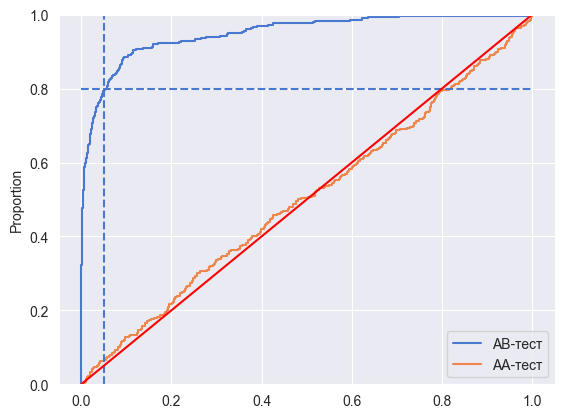

In [104]:
x_ = np.linspace(0, 1, 100)
sns.ecdfplot(results_AB, label='AB-тест')
sns.ecdfplot(results_AA, label='AА-тест')
plt.legend()
plt.vlines(x=0.05, ymin=0, ymax=1, linestyles='--')
plt.hlines(y=0.8, xmin=0, xmax=1, linestyles='--')
plt.plot(x_, x_, color='r')
plt.show()

In [127]:
arr_of_dates_ = purchases.transaction_datetime.unique()
results_AA_ = []
results_AB_ = []

NUM_REPEATS = 10
NUM_EXPERIMENTS = 200
SAMPLE_SIZE = 461
for _ in tqdm(range(int(NUM_EXPERIMENTS / NUM_REPEATS))):
    date_ = np.random.choice(arr_of_dates, size=1)
    date_2 = date_[0] + pd.Timedelta(days=6)
    date_ = date_[0]
    data_ = purchases[(purchases.transaction_datetime >= date_) & (purchases.transaction_datetime <= date_ + pd.Timedelta(days=6))]
    data_ = data_.groupby('client_id').sum_purchase.sum().reset_index()
    data_2 = purchases[(purchases.transaction_datetime >= date_2) & (purchases.transaction_datetime <= date_2 + pd.Timedelta(days=6))]
    data_2 = data_2.groupby('client_id').sum_purchase.sum().reset_index()
    data_ = pd.merge(data_, data_2, on='client_id', how='outer').fillna(0)
    data_temp = data_.iloc[:, 2] - data_.iloc[:, 1]
    avg_score = data_temp.mean()
    for i in range(NUM_REPEATS):
        smpl = data_temp.sample(SAMPLE_SIZE)
        results_AA_.append(scipy.stats.ttest_1samp(smpl, avg_score).pvalue)

100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


Мы также видим, что одновыборочный t-тест корректно работает для определения среднего, значит, им можно спокойно пользоваться на реальных исторических данных.

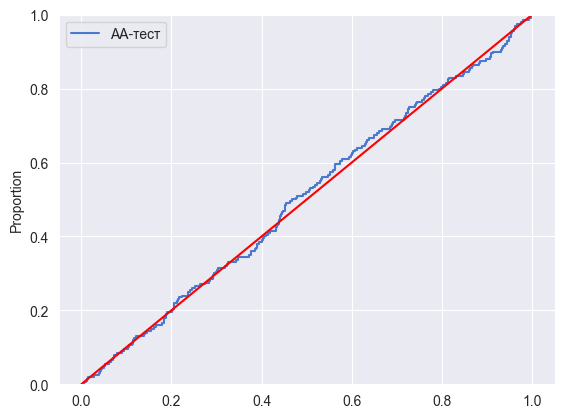

In [128]:
x_ = np.linspace(0, 1, 100)
sns.ecdfplot(results_AA_, label='AА-тест')
plt.legend()
plt.plot(x_, x_, color='r')
plt.show()

In [129]:
pd.read_csv('products.csv', nrows=1)

,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.4,0,0


In [133]:
clients_and_stores = pd.read_csv('purchases.csv', usecols=['client_id', 'transaction_id', 'store_id', 'transaction_datetime'])

In [137]:
clients_and_stores = clients_and_stores.drop_duplicates()

In [138]:
clients_and_stores.transaction_datetime = pd.to_datetime(clients_and_stores.transaction_datetime).dt.date

In [139]:
clients_and_stores.head()

,client_id,transaction_id,transaction_datetime,store_id
0,000012768d,7e3e2e3984,2018-12-01,54a4a11a29
19,000012768d,c1ca85d462,2018-12-16,ed8d2683fd
30,000012768d,6a0e96d0bc,2019-03-08,017c89b915
46,000012768d,b34f23306e,2019-03-14,017c89b915
52,000036f903,12b218b054,2018-11-28,6381a55c22


In [141]:
clients_and_stores.to_csv('clients_and_stores.csv', index=False)

In [143]:
cls_strs = clients_and_stores.groupby('client_id').store_id.nunique().reset_index()

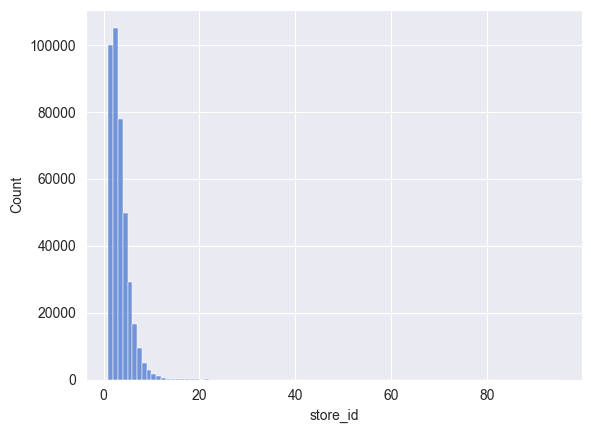

In [145]:
sns.histplot(cls_strs.store_id, binwidth=1)
plt.show()

In [194]:
outliers = purchases[purchases.client_id.isin(cls_strs[cls_strs.store_id > 20].client_id)]
outliers_grp = outliers.groupby('client_id').agg({"sum_purchase": ['count', 'sum']}).reset_index()
outliers_grp.columns = ['client_id', 'num_purch', 'sum_purch']

not_outliers =purchases[purchases.client_id.isin(cls_strs[cls_strs.store_id <= 20].client_id)]
not_outliers_grp = not_outliers.groupby('client_id').agg({"sum_purchase": ['count', 'sum']}).reset_index()
not_outliers_grp.columns = ['client_id', 'num_purch', 'sum_purch']

outliers_grp['outlier'] = 1
df2 = not_outliers_grp.sample(outliers_grp.shape[0])
df2['outlier'] = 0
df = pd.concat((outliers_grp, df2), axis=0)

model1 = LinearRegression()
model2 = LinearRegression()
model1.fit(sm.add_constant(outliers_grp.num_purch), outliers_grp.sum_purch)
X_out = [outliers_grp.num_purch.min(), outliers_grp.num_purch.max()]
y_out = model1.predict(sm.add_constant(X_out))

model2.fit(sm.add_constant(df2.num_purch), df2.sum_purch)
X_not_out = [df2.num_purch.min(), df2.num_purch.max()]
y_not_out = model2.predict(sm.add_constant(X_not_out))

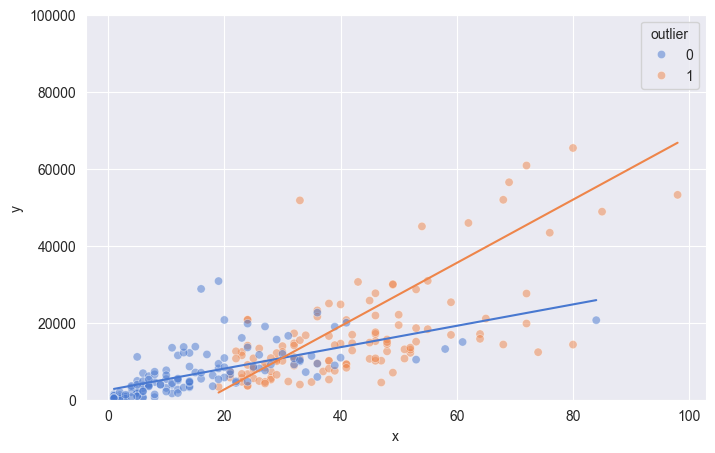

In [217]:
plt.figure(figsize=(8, 5))
plt.ylim(0, 100000)
sns.lineplot(pd.DataFrame(np.vstack((np.array(X_not_out), y_not_out)).T, columns=['x', 'y']), x='x', y='y')
sns.lineplot(pd.DataFrame(np.vstack((np.array(X_out), y_out)).T, columns=['x', 'y']), x='x', y='y')
sns.scatterplot(df, x='num_purch', y='sum_purch', hue='outlier', alpha=0.5)
plt.show()

In [222]:
BOUND = 10

outliers = purchases[purchases.client_id.isin(cls_strs[cls_strs.store_id > BOUND].client_id)]
outliers_grp = outliers.groupby('client_id').agg({"sum_purchase": ['count', 'sum']}).reset_index()
outliers_grp.columns = ['client_id', 'num_purch', 'sum_purch']

not_outliers =purchases[purchases.client_id.isin(cls_strs[cls_strs.store_id <= BOUND].client_id)]
not_outliers_grp = not_outliers.groupby('client_id').agg({"sum_purchase": ['count', 'sum']}).reset_index()
not_outliers_grp.columns = ['client_id', 'num_purch', 'sum_purch']

outliers_grp['outlier'] = 1
df2 = not_outliers_grp.sample(outliers_grp.shape[0])
df2['outlier'] = 0
df = pd.concat((outliers_grp, df2), axis=0)

model1 = LinearRegression()
model2 = LinearRegression()
model1.fit(sm.add_constant(outliers_grp.num_purch), outliers_grp.sum_purch)
X_out = [outliers_grp.num_purch.min(), outliers_grp.num_purch.max()]
y_out = model1.predict(sm.add_constant(X_out))

model2.fit(sm.add_constant(df2.num_purch), df2.sum_purch)
X_not_out = [df2.num_purch.min(), df2.num_purch.max()]
y_not_out = model2.predict(sm.add_constant(X_not_out))

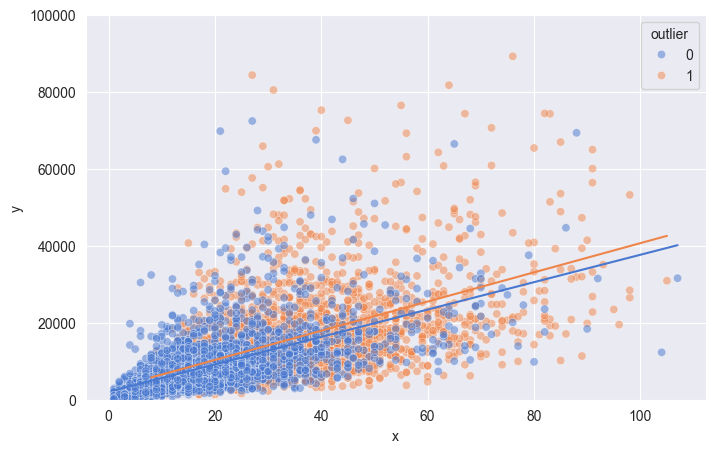

In [223]:
plt.figure(figsize=(8, 5))
plt.ylim(0, 100000)
sns.lineplot(pd.DataFrame(np.vstack((np.array(X_not_out), y_not_out)).T, columns=['x', 'y']), x='x', y='y')
sns.lineplot(pd.DataFrame(np.vstack((np.array(X_out), y_out)).T, columns=['x', 'y']), x='x', y='y')
sns.scatterplot(df, x='num_purch', y='sum_purch', hue='outlier', alpha=0.5)
plt.show()